# How Anxcor uses XArray to simplify timeseries operations. 
## Part I. Obspy Stream Conversion to XArray.DataArray

[ObsPy](https://www.obspy.org) is an incredibly versatile, well-tested, and useful seismology analysis library. With a strong scripting background and an intermediate knowledge of multiprocessing, ambient noise crosscorrelation could be done almost entirely with it.

However, the base timeseries containers of ```ObsPy```, namely [Stream](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html) and [Trace](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.html) are not suited for tensorization (Evaluating mathematical operations in terms of tensor operations). This is unfortunate, because setting up ambient noise crosscorrelation in a tensorized form provides a concise way to pose the problem for parallel processing. For this reason, ```Anxcor``` has been designed to integrate with ```ObsPy```, but ultimately carry out the bulk of its operations in tensorized form using the [xarray](http://xarray.pydata.org/en/stable/) package.

XArray's [DataArray](http://xarray.pydata.org/en/stable/data-structures.html) and [DataSet](http://xarray.pydata.org/en/stable/data-structures.html#dataset) objects provide [pandas](https://pandas.pydata.org) [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)-like access to [numpy.ndarray](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html) tensors. These notebook examples illustrate their basic functionality by converting ```Obspy``` ```Stream``` objects to ```xarray.DataArray``` objects using ```Anxcor```, eventually applying specific processing routines to the resultant tensors. 

The execution of these steps can be handled automatically by ```Anxcor```. You can, of course, import and use ```Anxcor``` processing functions as you wish, but its not strictly required. ```Dask```, a python parallel processing library, is used by ```Anxcor``` to parallelize these routines; it is not required for these tutorials. Note that even if ```Dask``` is not used, tensorized operations performed on ```xarray``` objects are vectorized, which may reduce computation time below that of naiive sequential processing using ```ObsPy``` routines.

Lets set up the matplotlib inline environmental variable and import the libraries required for this example.

In [1]:
from anxcor.xarray_routines import XArrayConverter
from obspy import read
import matplotlib.pyplot as plt
%matplotlib inline

dask is not installed. Anxcor will now operate without dask in single threaded mode


```ObsPy```'s ```read()``` function yields an Earthquake waveform as seen on one station over three channels. The ```Stream``` object is an iterable list of ```ObsPy``` ```Trace```'s, which contain metadata associated with each waveform. 

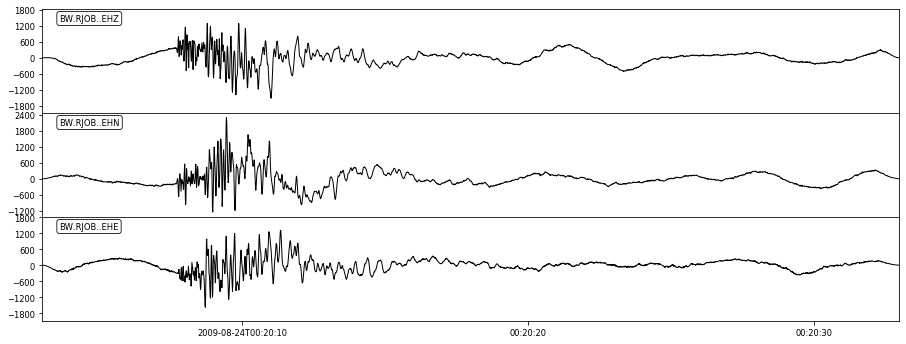

In [2]:
stream= read()
fig=plt.figure(figsize=(14,5))
stream.plot(fig=fig)
plt.show()

### Conversion Requirements

```Anxcor``` first needs to convert a stream object with any number of traces into an ```xarray.DataArray``` with the ```XArrayConverter``` object. ```XArrayConverter``` uses the following assumptions when converting traces inside a single ```Stream``` object:
 * all traces have the same sampling rate
 * all traces have the same starttime
 * all traces have the **exact** same number of points/duration
 * all traces come from the same station/location
 
It relies on the user to ensure this condition holds true. See the Anxcor_Data tutorials for more info

In [3]:
converter = XArrayConverter()
xarray    = converter(stream)
xarray

<xarray.DataArray 'default' (channel: 3, station_id: 1, time: 3000)>
array([[[ 0.        ,  0.00694644,  0.07597424, ...,  1.93449584,
          0.98196204,  0.44196924]],

       [[ 0.        ,  0.00604377,  0.07638602, ...,  1.00600271,
          0.49260146,  0.25438282]],

       [[ 0.        , -0.01443364, -0.17701521, ...,  0.82668861,
          0.43544484,  0.19766389]]])
Coordinates:
  * channel     (channel) <U3 'EHZ' 'EHN' 'EHE'
  * station_id  (station_id) <U7 'BW.RJOB'
  * time        (time) datetime64[ns] 2009-08-24T00:20:03 ... 2009-08-24T00:20:33
Attributes:
    delta:       0.01
    starttime:   0
    operations:  xconvert

### Metadata and Coordinates
The produced ```xarray.DataArray``` is 3 Dimensional, with dimensions(coordinates) of channel, station_id, and time. Note that ```Anxcor``` converts the network and station name into a single coordinate like so: 

"{network}.{station}". 

In this case, the station_id dimension has only one coordinate, "BW.RJOB". 

```Anxcor``` by default only retains metadata needed for crosscorrelations, relying on the user to retain additional pertinent metadata. The metadata that is retained is contained in an ordered-dict property of the ```xarray.DataArray```.

In [4]:
xarray.attrs

{'delta': 0.01, 'starttime': 0, 'operations': 'xconvert'}

At this stage of processing, the xarray only contains the sampling interval as ```delta```, the starttime as a ```UTCDateTime``` timestamp, and a string of data cataloging the applied operations to the data.
We've only converted the data to a DataArray, so the operations value only displays 'xconvert' for now.

```DataArrays``` also have names which are accessible via the ```name``` attribute. Anxcor uses this name attribute to further specify the *type* of seismic data contained by the ```DataArray```. By default, all traces provided to anxcor are given the 'default' name attribute.

In [7]:
print('The name for this xarray is: {}'.format(xarray.name))

The name for this xarray is: 'default'


To assign a specific name to the dataset, assign all traces in the delivered stream a ```name``` attribute by attaching it to every ```trace.stats``` object inside the provided ```Stream```. 

**WARNING**. Adding multiple names to xarray streams will cause the resulting crosscorrelations to be incredibly sparse. Theoretically, there are simple ways to change the numpy backend to account for this, but at the moment most xarray operations will only happen across dense arrays. If you want fast and low memory usage operation of ```Anxcor```, keep all names the same.

In [8]:
stream= read()
for trace in stream:
    trace.stats.name='my_assigned_data_type'
named_xarray = converter(stream,starttime=0,station=0)
print('The name for this xarray is: {}'.format(named_xarray.name))

The name for this xarray is: 'my_assigned_data_type'


### Plotting With XArray.DataArrays

```DataArray```s have built in plotting operations that work on 2D arrays. Since our array is 3D, we need to first squeeze out the size 1 station_id dimension to plot. Note that this will not work on N-dimensional Arrays with no length=1 dimensions. For more information on plotting ```xarray``` objects, check out http://xarray.pydata.org/en/stable/plotting.html.

/anaconda3/envs/anxcor_dev/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


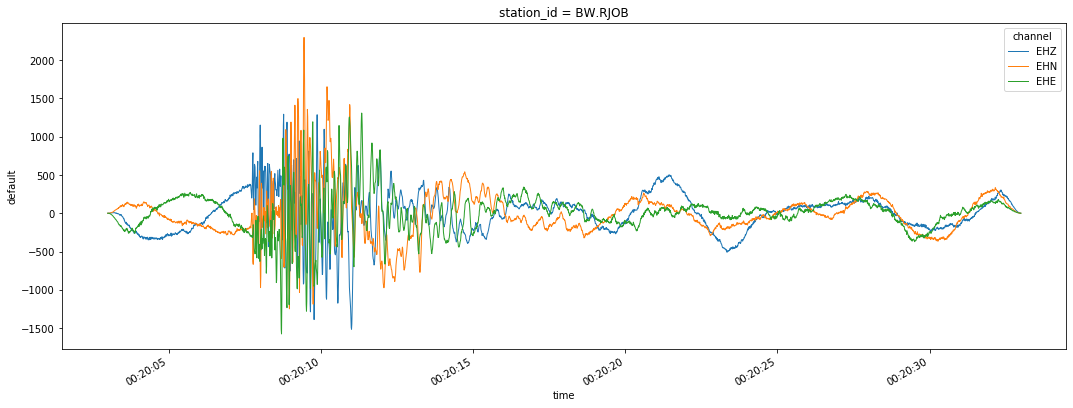

In [9]:
xarray_squeezed = xarray.squeeze()
xarray_squeezed.plot.line(x='time',aspect=3, size=6,linewidth=1)
plt.show()

In the next notebook, we'll look at ```Anxcor```'s basic signal processing routines